In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
BASE_DIR = '/content/drive/MyDrive/crop_part1'


In [ ]:

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/9780 [00:00<?, ?it/s]

In [ ]:

df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()


,image,age,gender
0,/content/drive/MyDrive/crop_part1/3_1_0_201701...,3,1
1,/content/drive/MyDrive/crop_part1/3_1_0_201701...,3,1
2,/content/drive/MyDrive/crop_part1/3_1_0_201701...,3,1
3,/content/drive/MyDrive/crop_part1/3_1_0_201701...,3,1
4,/content/drive/MyDrive/crop_part1/3_1_0_201701...,3,1


In [ ]:

gender_dict = {0:'Male', 1:'Female'}

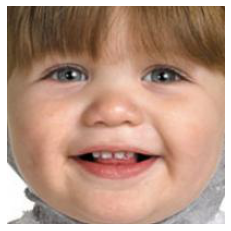

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

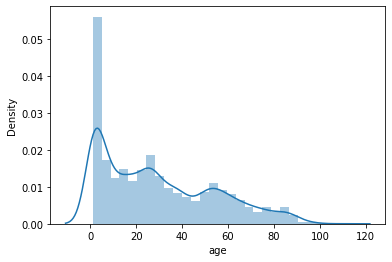

In [ ]:
sns.distplot(df['age'])

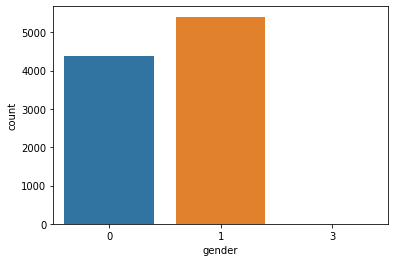

In [ ]:
sns.countplot(df['gender'])

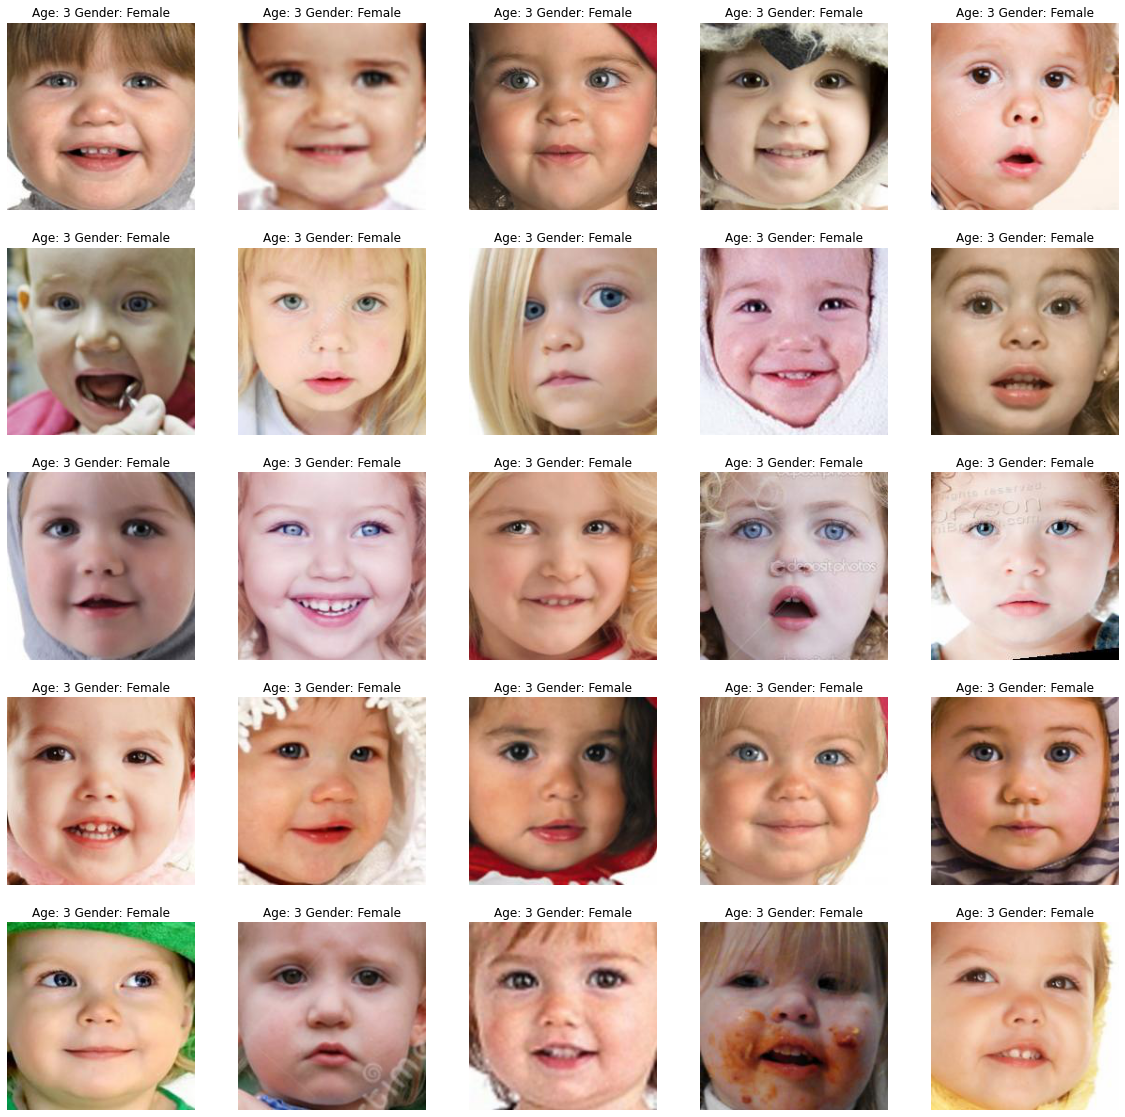

In [ ]:

plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
   
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])


  0%|          | 0/9780 [00:00<?, ?it/s]

In [ ]:
X.shape

(9780, 128, 128, 1)

In [ ]:

X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)


dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

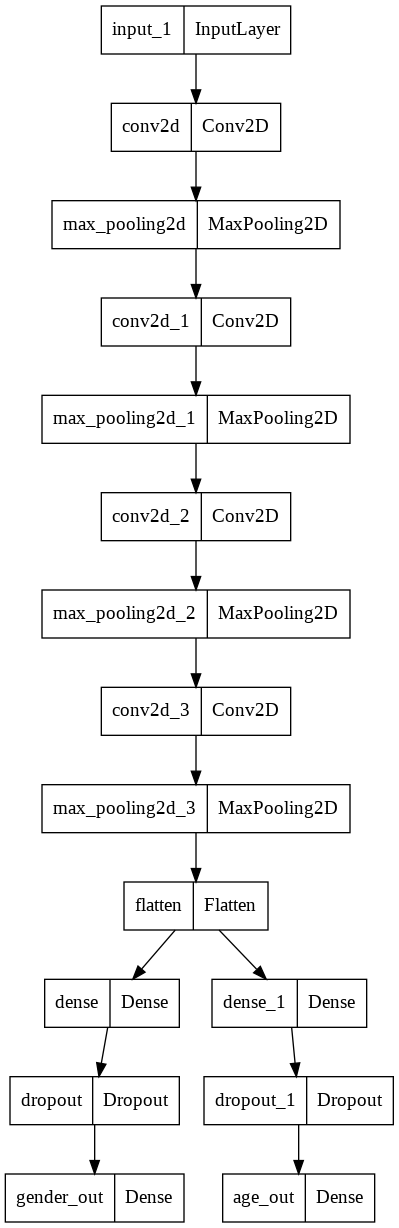

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


Epoch 1/30
245/245 [==============================] - 275s 1s/step - loss: 21.3969 - gender_out_loss: 0.7152 - age_out_loss: 20.6817 - gender_out_accuracy: 0.5429 - age_out_accuracy: 0.0353 - val_loss: 27.6027 - val_gender_out_loss: 0.7010 - val_age_out_loss: 26.9018 - val_gender_out_accuracy: 0.5112 - val_age_out_accuracy: 0.4274
Epoch 2/30
245/245 [==============================] - 273s 1s/step - loss: 16.1401 - gender_out_loss: 0.5934 - age_out_loss: 15.5467 - gender_out_accuracy: 0.6881 - age_out_accuracy: 0.0297 - val_loss: 10.5043 - val_gender_out_loss: 0.6867 - val_age_out_loss: 9.8176 - val_gender_out_accuracy: 0.5746 - val_age_out_accuracy: 0.3978
Epoch 3/30
245/245 [==============================] - 270s 1s/step - loss: 13.4902 - gender_out_loss: 0.5228 - age_out_loss: 12.9674 - gender_out_accuracy: 0.7400 - age_out_accuracy: 0.0199 - val_loss: 5.5420 - val_gender_out_loss: 0.6420 - val_age_out_loss: 4.9000 - val_gender_out_accuracy: 0.5987 - val_age_out_accuracy: 0.1411
Epoc

In [ ]:
model.save('agedender.h5')

In [ ]:
from keras.models import load_model
model=load_model('/content/agedender.h5')


Original Gender: Male Original Age: 41
Predicted Gender: Male Predicted Age: 39


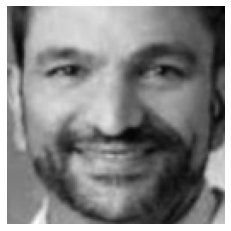

In [ ]:
image_index = 5113
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');